In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay

import scikitplot as skplt
from scikitplot.helpers import binary_ks_curve


import optuna
from optuna.trial import TrialState
import pickle

/home/guilhermemaciel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Carregando o dataset

In [2]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [3]:
X_train = df_train.drop(['satisfaction'], axis=1)
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1)
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1)
y_test = df_test['satisfaction'].values

## Declarando as funções de avaliação do modelo

In [4]:
def plot_roc_curve(y_pred: np.array, y_test: np.array) -> None:
    
    # Obter as probabilidades da classe positiva
    y_pred_positive = y_pred[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_positive)
    roc_auc = roc_auc_score(y_test, y_pred_positive)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})' )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()



In [5]:
def plot_confusion_matrix(y_pred: np.array, y_test: np.array) -> None:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [6]:
def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [7]:
def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

##### Ajustando variáveis one-hot-encoding para string

In [8]:
columns_to_concat = [
    'Age',
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'Gender',
    'Customer Type',
    'Type of Travel',
    'Class'
]

In [9]:
def one_hot_to_string(df: pd.DataFrame, col: list) -> pd.DataFrame:
    for prefix in col:
        cols_to_concat = [c for c in df.columns if c.startswith(prefix + '_')]
        
        if cols_to_concat:
            df[prefix] = df[cols_to_concat].astype(str).agg(''.join, axis=1)
            
            df.drop(cols_to_concat, axis=1, inplace=True)
            
    return df

In [10]:
X_train = one_hot_to_string(df=X_train, col=columns_to_concat)
X_val = one_hot_to_string(df=X_val, col=columns_to_concat)
X_test = one_hot_to_string(df=X_test, col=columns_to_concat)

In [11]:
X_train.columns

Index(['Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness', 'Age',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Gender', 'Customer Type', 'Type of Travel',
       'Class'],
      dtype='object')

#### Retirando features com alta correlação e que não possuem tanta relevância

Age, Gate Location, Gender, Departure Delay in Minutes (Alta correlação com Arrival Dealy in minutes), Departure/Arrival time convenient

In [12]:
X_train = X_train.drop(['Age', 'Gate location', 'Gender', 'Departure Delay in Minutes', 'Departure/Arrival time convenient'], axis=1)
X_val = X_val.drop(['Age', 'Gate location', 'Gender', 'Departure Delay in Minutes', 'Departure/Arrival time convenient'], axis=1)
X_test = X_test.drop(['Age', 'Gate location', 'Gender', 'Departure Delay in Minutes', 'Departure/Arrival time convenient'], axis=1)


In [13]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

##### Criando o modelo da Random Forest

In [14]:
model = RandomForestClassifier(
    n_estimators=10,
    max_depth=10,
    criterion='gini',
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=df_train.shape[1],
)

In [15]:
model.fit(X=X_train, y=y_train)

RandomForestClassifier(max_depth=10, max_features=35, n_estimators=10)

## Avaliando o modelo

### Conjunto de Validação

In [16]:
y_pred_val_class = model.predict(X_val)
y_pred_val_scores = model.predict_proba(X_val)

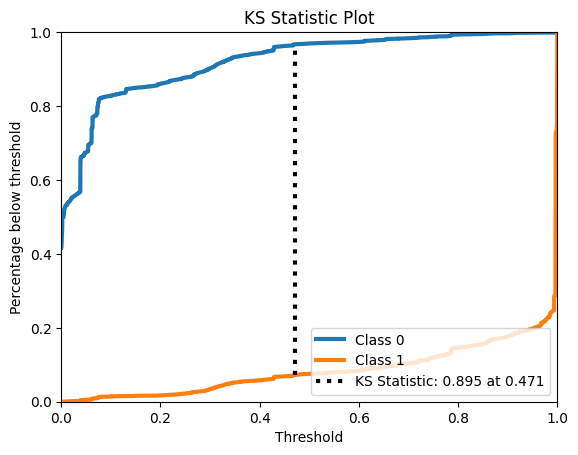



Random Forest - Validation

Accuracy:         0.9468
Recall:           0.9244
Precision:        0.9678
F1:               0.9456
AUROC:            0.9891
AUPR:             0.9896


In [17]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, y_pred_val_class, y_pred_val_scores)
print('\n\nRandom Forest - Validation')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

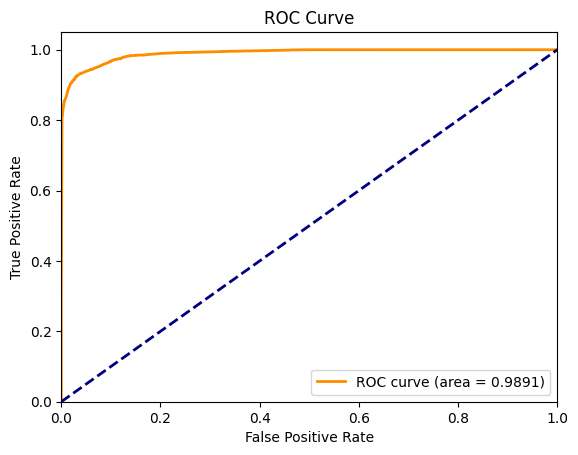

In [18]:
plot_roc_curve(y_pred_val_scores, y_val)

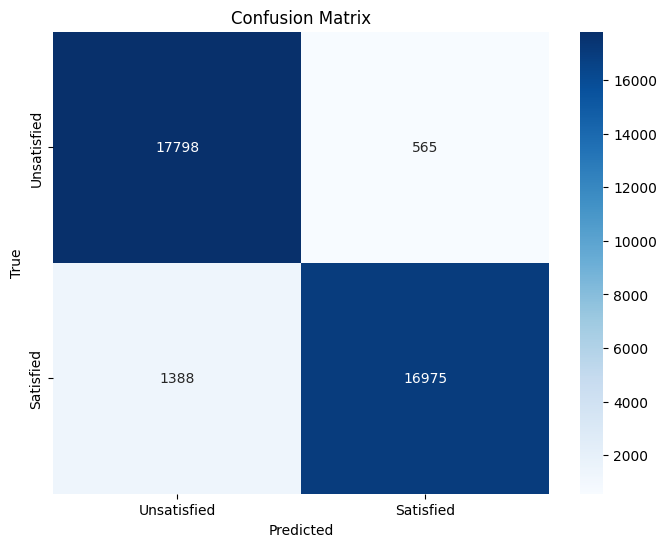

In [19]:
plot_confusion_matrix(y_pred=y_pred_val_class, y_test=y_val)

### Conjunto de Teste

In [20]:
y_pred_test_class = model.predict(X_test)
y_pred_test_scores = model.predict_proba(X_test)

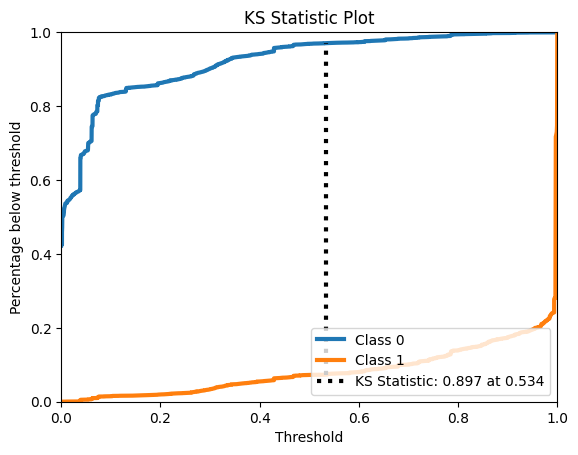



Random Forest - Test

Accuracy:         0.9506
Recall:           0.9273
Precision:        0.9576
F1:               0.9422
AUROC:            0.9894
AUPR:             0.9874


In [21]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_test_class, y_pred_test_scores)
print('\n\nRandom Forest - Test')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

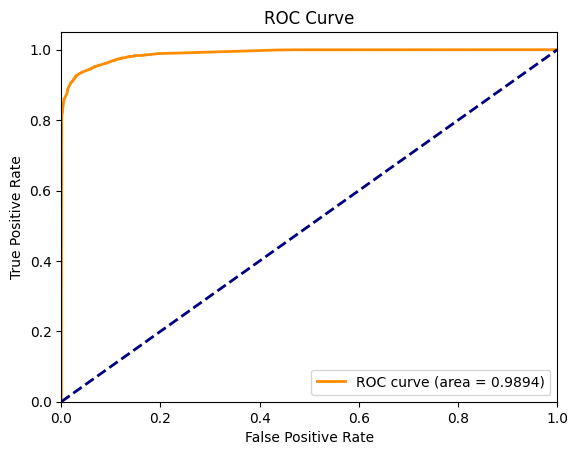

In [22]:
plot_roc_curve(y_pred_test_scores, y_test)

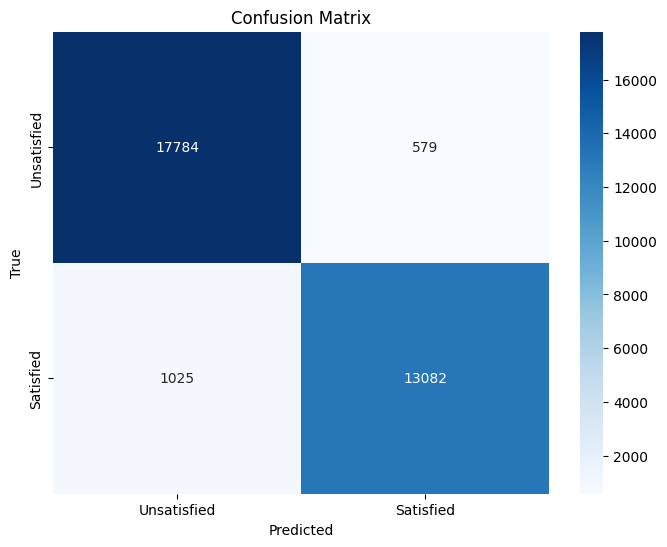

In [23]:
plot_confusion_matrix(y_pred=y_pred_test_class, y_test=y_test)

#### Usando o Optune para encontrar os melhores Hiperparâmetros

#### Primeiro iremos criar uma função objetivo, com foco em maximizar o AOC

In [24]:
def objective(trial):

    global x_train
    global y_train

    global X_test
    global y_test
    
    # Sugerir valores para os hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    trial.set_user_attr("n_estimators", n_estimators)
    trial.set_user_attr("max_depth", max_depth)
    trial.set_user_attr("min_samples_split", min_samples_split)
    trial.set_user_attr("min_samples_leaf", min_samples_leaf)
    
    # Criar o modelo RandomForest com os hiperparâmetros sugeridos
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=51
    )

    model.fit(X=X_train, y=y_train)
    
    # Avaliar o modelo usando test k-s
    y_pred_test_class = model.predict(X_test)
    y_pred_test_scores = model.predict_proba(X_test)

    thresholds, pct1, pct2, ks_statistic, \
        max_distance_at, classes = binary_ks_curve(y_test, y_pred_test_scores[:, 1].ravel())

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_test_class, y_pred_test_scores)
    print(f'\n\nRandom Forest\nn_estimators: {n_estimators}\nmax_depth:{max_depth}\nmin_samples_split:{min_samples_split}\nmin_samples_leaf:{min_samples_leaf}')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    

    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("f1", precision)
    trial.set_user_attr("auroc", auroc)
    trial.set_user_attr("ks_statistic", ks_statistic)
    trial.set_user_attr("max_distance_at", max_distance_at)

    pickle.dump(model, open(f'../models/rf_{trial.number}.pkl', 'wb'))
    
    return auroc, ks_statistic


[I 2024-07-30 13:32:16,402] A new study created in memory with name: no-name-d59aaa63-4df8-406c-9803-ad82cdddd032


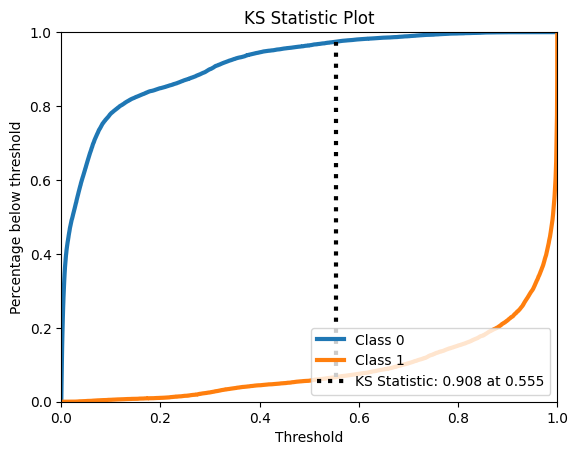

[I 2024-07-30 13:32:29,949] Trial 0 finished with values: [0.99208334295032, 0.908076613063195] and parameters: {'n_estimators': 356, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 9}. 




Random Forest
n_estimators: 356
max_depth:17
min_samples_split:4
min_samples_leaf:9

Accuracy:         0.9550
Recall:           0.9431
Precision:        0.9529
F1:               0.9480
AUROC:            0.9921
AUPR:             0.9909


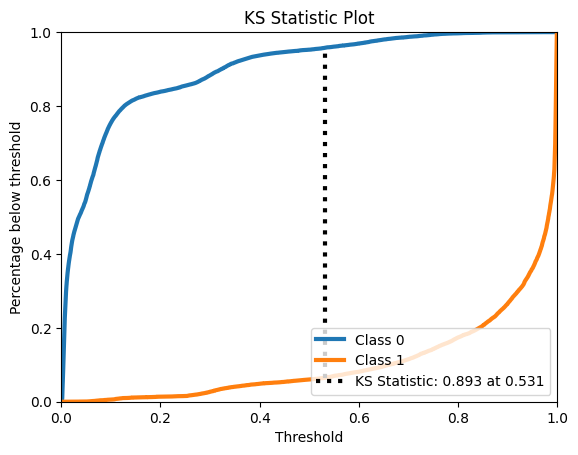

[I 2024-07-30 13:32:32,509] Trial 1 finished with values: [0.9899586191054921, 0.8930871849543227] and parameters: {'n_estimators': 69, 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 9}. 




Random Forest
n_estimators: 69
max_depth:11
min_samples_split:11
min_samples_leaf:9

Accuracy:         0.9470
Recall:           0.9398
Precision:        0.9382
F1:               0.9390
AUROC:            0.9900
AUPR:             0.9885


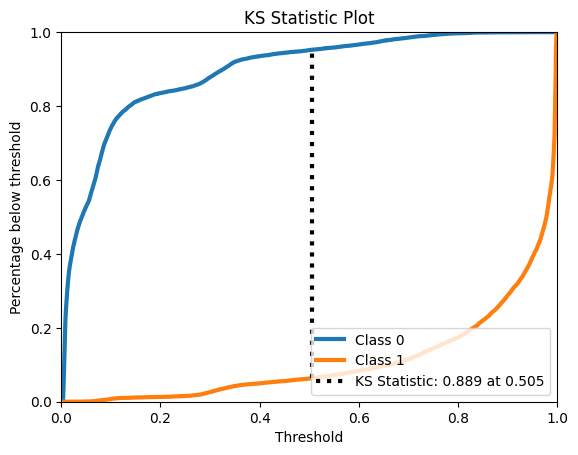

[I 2024-07-30 13:32:46,241] Trial 2 finished with values: [0.9892024083783365, 0.8892770168928638] and parameters: {'n_estimators': 429, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 8}. 




Random Forest
n_estimators: 429
max_depth:10
min_samples_split:13
min_samples_leaf:8

Accuracy:         0.9452
Recall:           0.9374
Precision:        0.9366
F1:               0.9370
AUROC:            0.9892
AUPR:             0.9877


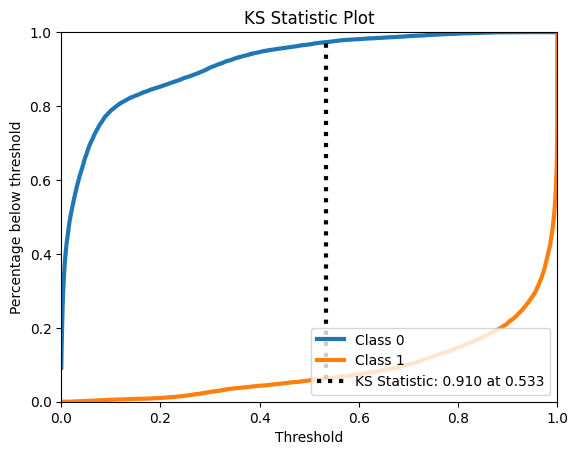

[I 2024-07-30 13:32:49,182] Trial 3 finished with values: [0.9923867050747011, 0.9104886092781961] and parameters: {'n_estimators': 68, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 7}. 




Random Forest
n_estimators: 68
max_depth:20
min_samples_split:12
min_samples_leaf:7

Accuracy:         0.9561
Recall:           0.9424
Precision:        0.9559
F1:               0.9491
AUROC:            0.9924
AUPR:             0.9912


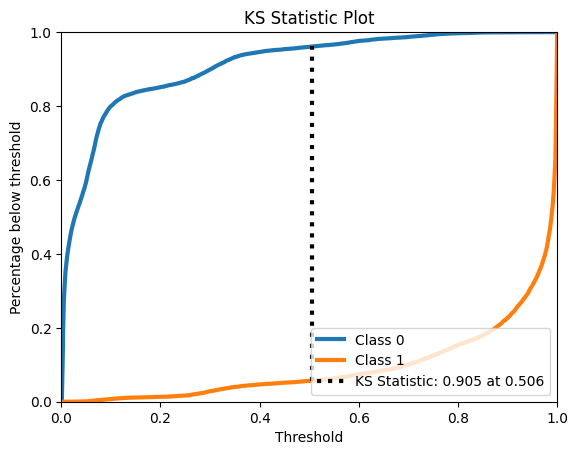

[I 2024-07-30 13:33:01,360] Trial 4 finished with values: [0.9915733483119371, 0.9047840618137474] and parameters: {'n_estimators': 344, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1}. 




Random Forest
n_estimators: 344
max_depth:12
min_samples_split:9
min_samples_leaf:1

Accuracy:         0.9532
Recall:           0.9439
Precision:        0.9480
F1:               0.9460
AUROC:            0.9916
AUPR:             0.9904


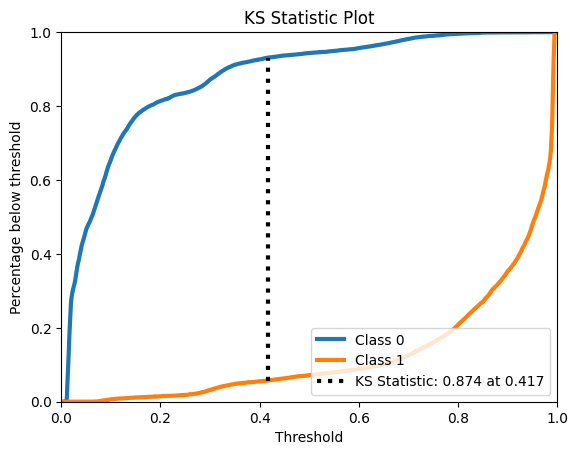

[I 2024-07-30 13:33:11,653] Trial 5 finished with values: [0.9862297162697305, 0.8740311756976801] and parameters: {'n_estimators': 378, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 10}. 




Random Forest
n_estimators: 378
max_depth:8
min_samples_split:10
min_samples_leaf:10

Accuracy:         0.9367
Recall:           0.9281
Precision:        0.9263
F1:               0.9272
AUROC:            0.9862
AUPR:             0.9843


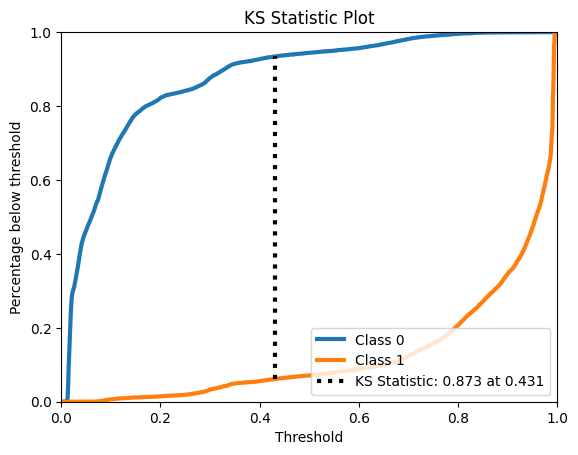

[I 2024-07-30 13:33:22,520] Trial 6 finished with values: [0.9864790785076587, 0.8732036110797429] and parameters: {'n_estimators': 409, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1}. 




Random Forest
n_estimators: 409
max_depth:8
min_samples_split:2
min_samples_leaf:1

Accuracy:         0.9375
Recall:           0.9288
Precision:        0.9274
F1:               0.9281
AUROC:            0.9865
AUPR:             0.9845


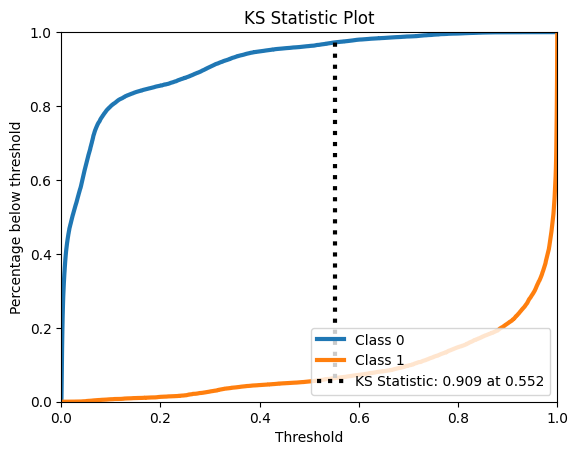

[I 2024-07-30 13:33:33,586] Trial 7 finished with values: [0.9921550635701442, 0.9085211311262429] and parameters: {'n_estimators': 308, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 4}. 




Random Forest
n_estimators: 308
max_depth:14
min_samples_split:7
min_samples_leaf:4

Accuracy:         0.9550
Recall:           0.9453
Precision:        0.9508
F1:               0.9480
AUROC:            0.9922
AUPR:             0.9910


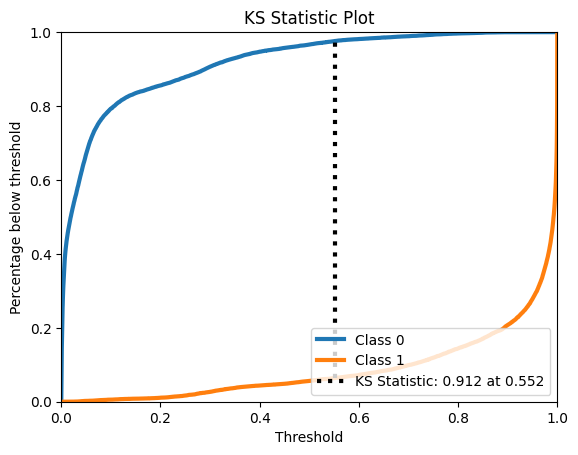

[I 2024-07-30 13:33:44,373] Trial 8 finished with values: [0.9925055677478807, 0.912240659209583] and parameters: {'n_estimators': 286, 'max_depth': 17, 'min_samples_split': 14, 'min_samples_leaf': 6}. 




Random Forest
n_estimators: 286
max_depth:17
min_samples_split:14
min_samples_leaf:6

Accuracy:         0.9565
Recall:           0.9438
Precision:        0.9556
F1:               0.9496
AUROC:            0.9925
AUPR:             0.9914


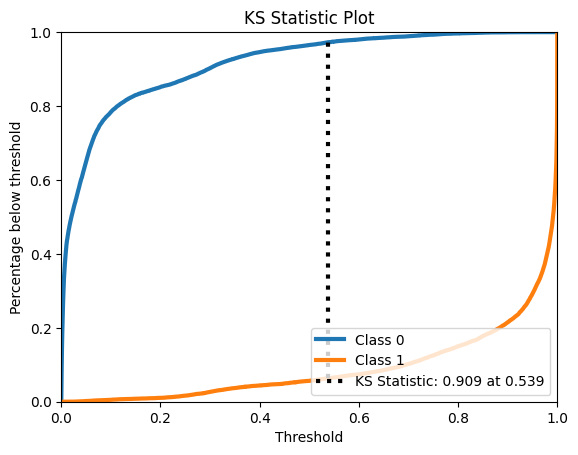

[I 2024-07-30 13:33:57,056] Trial 9 finished with values: [0.9922589019334924, 0.9093821105504235] and parameters: {'n_estimators': 339, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 8}. 




Random Forest
n_estimators: 339
max_depth:17
min_samples_split:3
min_samples_leaf:8

Accuracy:         0.9557
Recall:           0.9436
Precision:        0.9541
F1:               0.9488
AUROC:            0.9923
AUPR:             0.9911


In [25]:
study = optuna.create_study(directions=['maximize', 'maximize'])
study.optimize(objective, n_trials=10)

#### Salvando os resultados no csv e visualizando os resultados

In [26]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values(['values_0', 'values_1']) 

csv_file = "../results/optuna_results_rf_df2.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [27]:
df_existing

,number,values_0,values_1,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,user_attrs_accuracy,user_attrs_auroc,user_attrs_f1,user_attrs_ks_statistic,user_attrs_max_depth,user_attrs_max_distance_at,user_attrs_min_samples_leaf,user_attrs_min_samples_split,user_attrs_n_estimators,user_attrs_precision,user_attrs_recall,system_attrs_nsga2:generation
5,5,0.986230,0.874031,8,10,10,378,0.936680,0.986230,0.926282,0.874031,8,0.417085,10,10,378,0.926282,0.928121,0
6,6,0.986479,0.873204,8,1,2,409,0.937481,0.986479,0.927444,0.873204,8,0.431321,1,2,409,0.927444,0.928759,0
2,2,0.989202,0.889277,10,8,13,429,0.945242,0.989202,0.936610,0.889277,10,0.504926,8,13,429,0.936610,0.937407,0
1,1,0.989959,0.893087,11,9,11,69,0.946966,0.989959,0.938221,0.893087,11,0.530691,9,11,69,0.938221,0.939817,0
4,4,0.991573,0.904784,12,1,9,344,0.953157,0.991573,0.948028,0.904784,12,0.505964,1,9,344,0.948028,0.943929,0
0,0,0.992083,0.908077,17,9,4,356,0.955035,0.992083,0.952875,0.908077,17,0.554764,9,4,356,0.952875,0.943149,0
7,7,0.992155,0.908521,14,4,7,308,0.954974,0.992155,0.950802,0.908521,14,0.552084,4,7,308,0.950802,0.945275,0
9,9,0.992259,0.909382,17,8,3,339,0.955744,0.992259,0.954057,0.909382,17,0.538664,8,3,339,0.954057,0.943574,0
3,3,0.992387,0.910489,20,7,12,68,0.956113,0.992387,0.955925,0.910489,20,0.533341,7,12,68,0.955925,0.942440,0
8,8,0.992506,0.912241,17,6,14,286,0.956514,0.992506,0.955573,0.912241,17,0.551637,6,14,286,0.955573,0.943787,0


In [29]:
best_trial = study.best_trials[0]
print("\n-- Best Trial --")
print(f"  Accuracy:  {best_trial.user_attrs['accuracy']}")
print(f"  Precision: {best_trial.user_attrs['precision']}")
print(f"  Recall:    {best_trial.user_attrs['recall']}")
print(f"  F1 Score:  {best_trial.user_attrs['f1']}")
print(f"  auroc:  {best_trial.user_attrs['auroc']}")
print(f"  ks_statistic:  {best_trial.user_attrs['ks_statistic']}")
print(f"  max_distance_at:  {best_trial.user_attrs['max_distance_at']}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by auroc) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(study, target=lambda t: t.values[0])

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")


-- Best Trial --
  Accuracy:  0.9565137049584231
  Precision: 0.9555730998349243
  Recall:    0.9437867725242787
  F1 Score:  0.9555730998349243
  auroc:  0.9925055677478807
  ks_statistic:  0.912240659209583
  max_distance_at:  0.5516365698994726
  Parameters: 
    n_estimators:     286
    max_depth:        17
    min_samples_split: 14
    min_samples_leaf: 6

-- Overall Results (Ordered by auroc) --
   number  values_0  values_1  params_max_depth  params_min_samples_leaf  \
5       5  0.986230  0.874031                 8                       10   
6       6  0.986479  0.873204                 8                        1   
2       2  0.989202  0.889277                10                        8   
1       1  0.989959  0.893087                11                        9   
4       4  0.991573  0.904784                12                        1   
0       0  0.992083  0.908077                17                        9   
7       7  0.992155  0.908521                14              